In [1]:
import numpy as np
from PIL import Image
import cv2
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
import random
from tabulate import tabulate
from tqdm import tqdm
import pandas as pd
from scipy.stats import kurtosis, skew, iqr, norm, t, laplace, beta, multivariate_normal
from collections import Counter
np.set_printoptions(suppress=True)
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
n_images = 250
my_number = 7
images = []

while len(images) != n_images:
    idx = random.randint(7, 25000)
    image_name = f'im{idx}.jpg'
    image = cv2.imread(glob.glob(f'./mirflickr/{image_name}')[0])[:, :, 1]
    #images.append((image_name, image))
    images.append(image)
    
images = np.asarray(images)
assert len(images) == n_images

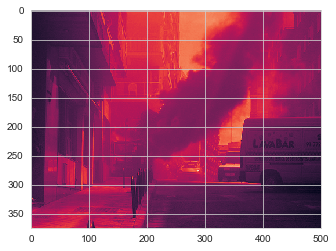

In [3]:
plt.imshow(images[0]);

# Для зеленого каналу кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:
 - Математичне очікування та дисперсію
 - Медіану та інтерквартильний розмах
 - Коефіцієнти асиметрії та ексцесу (нормалізований)
 - Гістограму значень яскравості пікселів (нормалізовану)

In [4]:
def count_statistics(img, normalized = False):
    math_exp_ = np.mean(img)
    variance_ = np.var(img)
    median_ = np.median(img)
    IQR_ = iqr(img.reshape(-1))
    if normalized:
        img = img / 255.
    kurtosis_ = kurtosis(img.reshape(-1), fisher=True)
    skew_ = skew(img.reshape(-1))
    return math_exp_, variance_, median_, IQR_, kurtosis_, skew_

In [5]:
def plot_hist(image, distribution_label = None):
    f, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True);
    plt.figure(figsize=(10, 6));
    sns.distplot(image.reshape(-1), kde=False, ax=axes[0]);
    if distribution_label == 't':
        sns.distplot(image.reshape(-1), fit=t, kde=False, ax=axes[1]);
    elif distribution_label == 'beta':
        sns.distplot(image.reshape(-1), fit=beta, kde=False, ax=axes[1]);
    elif distribution_label == 'laplace':
        sns.distplot(image.reshape(-1), fit=laplace, kde=False, ax=axes[1]);
    elif distribution_label == 'norm':
        sns.distplot(image.reshape(-1), fit=norm, kde=False, ax=axes[1]);
    plt.show();

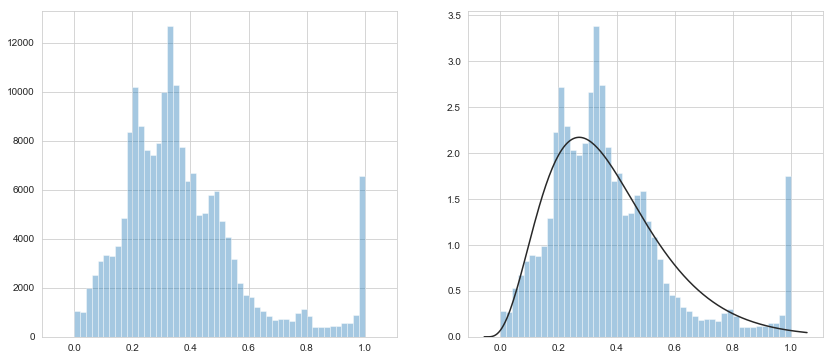

<Figure size 720x432 with 0 Axes>

In [6]:
plot_hist(images[116] / 255., 'beta');

# Провести обробку отриманих гістограм:
 - Провести апроксимацію гістограм з використанням імовірнісних розподілів:
     - Нормального (гаусового) розподілу
     - Розподілу Лапласа
     - Розподілу Стьюдента
     - Бета розподілу
 - Для кожної гістограми визначити найкращий тип апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення;
 - Побудувати розподіл отриманих апроксимацій за видом апроксимуючого розподілу;

In [7]:
def approx_array(img):
    img = img.reshape(-1)
    space = np.linspace(0, 255, num=256)
    sse_min = 10**100
    res_distribution = None
    arr = []
    for i in range(256):
        arr.append(Counter(img)[i])
    
    for distribution in [norm, t, laplace, beta]:
        # fit dist to data
        params = distribution.fit(img)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        pdf = distribution.pdf(space, loc=loc, scale=scale, *arg)
            
        sse = np.sum(np.power(arr - pdf, 2.0))
            
        if sse <= sse_min:
            sse_min = sse
            res_distribution = distribution
            
    return res_distribution, sse_min, str(res_distribution).split('.')[3].split(' ')[0].split('_')[0]

In [8]:
def sample_stats(image):
    math_exp, variance, median, IQR_, kurtosis_, skew_ = count_statistics(image)
    print('=========== stats table ===========')
    print(tabulate([['math expectation', math_exp], 
                ['variance', variance], 
                ['median', median],
                ['IQR', IQR_],
                ['kurtosis', kurtosis_], 
                ['skew', skew_]]))
    
    distribution, sse, distribution_label = approx_array(image)
    print('=========== distribution approximation =========')
    print('distribution : ', distribution_label)
    print('squared error : ', sse)
    
    print('=========== Plotting graph =========')
    plot_hist(image, distribution_label)

37
=========== stats table ===========
----------------  -----------
math expectation   111.882
variance          2425.08
median              94
IQR                 66
kurtosis             0.685023
skew                 0.997515
----------------  -----------
=========== distribution approximation =========
distribution :  laplace
squared error :  313620955.367018
=========== Plotting graph =========


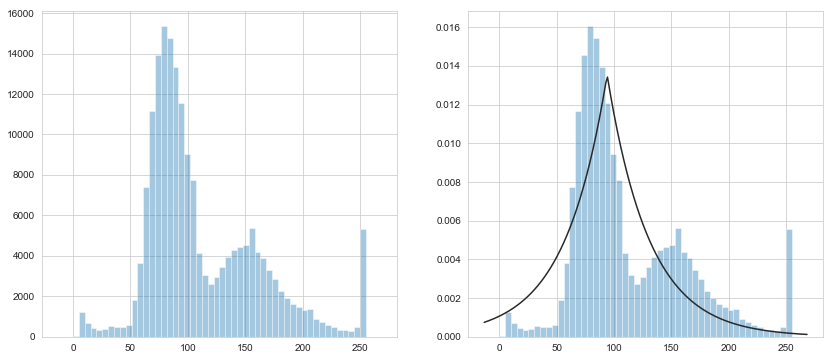

<Figure size 720x432 with 0 Axes>

************************************************************************************************************
165
=========== stats table ===========
----------------  -----------
math expectation    59.1521
variance          1267.18
median              78
IQR                 72
kurtosis            -0.459187
skew                -0.200971
----------------  -----------
=========== distribution approximation =========
distribution :  laplace
squared error :  365819360.25227016
=========== Plotting graph =========


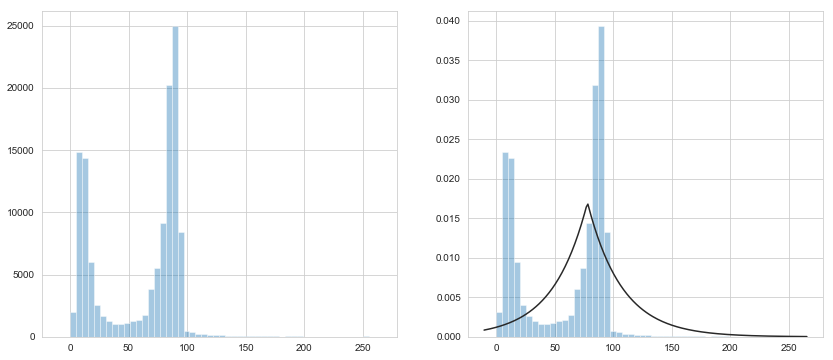

<Figure size 720x432 with 0 Axes>

************************************************************************************************************
63
=========== stats table ===========
----------------  ----------
math expectation   141.677
variance          1796.58
median             159
IQR                 43
kurtosis             1.15376
skew                -1.42946
----------------  ----------
=========== distribution approximation =========
distribution :  laplace
squared error :  461070160.378742
=========== Plotting graph =========


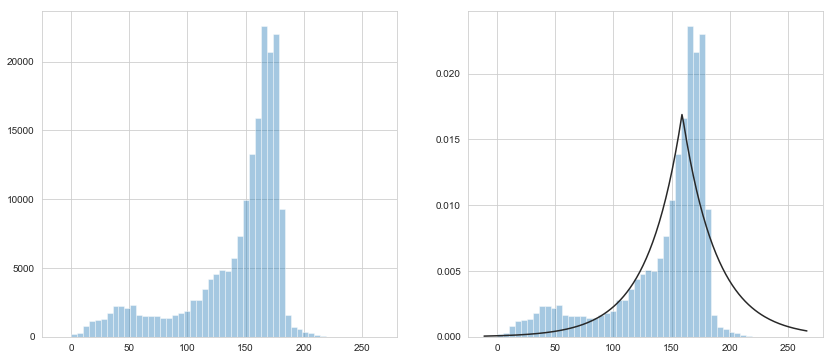

<Figure size 720x432 with 0 Axes>

************************************************************************************************************


In [9]:
n_samples = 3
for image_idx in np.random.choice(250, n_samples):
    print(image_idx)
    sample_stats(images[image_idx])
    print('******************************************************'*2)

In [10]:
distr_values = list()
for i, image in enumerate(images):
    _, _, distr = approx_array(image)
    print(i, distr)
    distr_values.append(distr)

0 laplace
1 beta
2 laplace
3 beta
4 t
5 laplace
6 laplace
7 laplace
8 laplace
9 beta
10 t
11 laplace
12 t
13 beta
14 t
15 beta
16 beta
17 beta
18 norm
19 beta
20 laplace
21 beta
22 laplace
23 laplace
24 beta
25 norm
26 laplace
27 beta
28 t
29 laplace
30 beta
31 laplace
32 beta
33 t
34 beta
35 t
36 laplace
37 laplace
38 beta
39 beta
40 beta
41 beta
42 laplace
43 laplace
44 laplace
45 t
46 beta
47 norm
48 laplace
49 beta
50 laplace
51 t
52 beta
53 beta
54 beta
55 beta
56 norm
57 t
58 laplace
59 beta
60 beta
61 beta
62 laplace
63 laplace
64 t
65 laplace
66 norm
67 beta
68 beta
69 beta
70 laplace
71 laplace
72 beta
73 laplace
74 beta
75 beta
76 laplace
77 norm
78 beta
79 laplace
80 norm
81 beta
82 beta
83 beta
84 laplace
85 beta
86 beta
87 t
88 laplace
89 beta
90 beta
91 t
92 laplace
93 laplace
94 beta
95 t
96 beta
97 laplace
98 beta
99 t
100 beta
101 laplace
102 norm
103 laplace
104 beta
105 beta
106 laplace
107 beta
108 beta
109 beta
110 laplace
111 laplace
112 beta
113 beta
114 beta
115

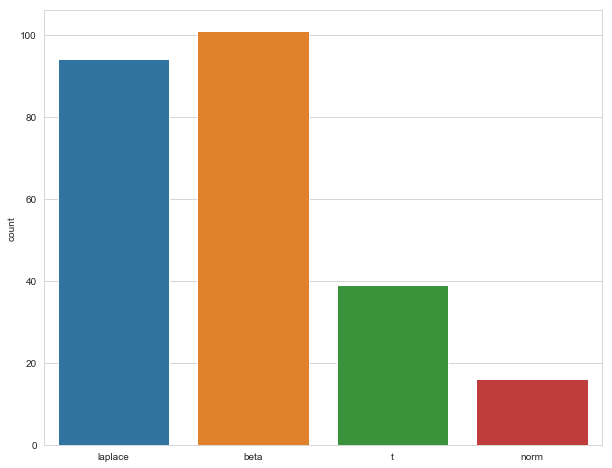

In [11]:
plt.figure(figsize=(10, 8))
sns.countplot(distr_values);

# Побудувати багатовимірні гаусові моделі
Сформувати вектори параметрів розподілу значень яскравості пікселів тестових зображень:
 - Математичне очікування
 - Математичне очікування та дисперсія
 - Математичне очікування, дисперсія та коефіцієнт асиметрії
 - Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу

In [12]:
def group_statistics(data):
    math_exp_arr = []
    var_arr = []
    skew_arr = []
    kurt_arr = []
    for image in data:
        image_stats = count_statistics(image)
        math_exp_arr.append(image_stats[0])
        var_arr.append(image_stats[1])
        skew_arr.append(image_stats[4])
        kurt_arr.append(image_stats[5])
    return math_exp_arr, var_arr, skew_arr, kurt_arr

In [13]:
math_exp, var, skew, kurt = group_statistics(images)

Визначити параметри багатовимірних гаусових моделей для кожної групи векторів, відобразити їх графічно та у вигляді таблиць.

mean_vec:  105.9661590844889
cov_matrix: 
 1857.9463071854193


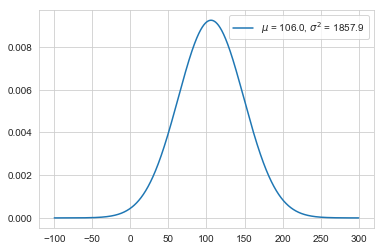

In [14]:
# 1. Math exp 
sample = math_exp
mean_vec_1 = np.mean(sample)
cov_matrix_1 = np.cov(sample)
print('mean_vec: ', mean_vec_1)
print('cov_matrix: \n', cov_matrix_1) 

x = np.linspace(start = -100, stop = 300, num = 2000)
y = norm(mean_vec_1, np.sqrt(cov_matrix_1)).pdf(x)
plt.plot(x, y, label = '$\mu$ = {}, $\sigma^2$ = {}'.format(np.round(mean_vec_1, 1), np.round(cov_matrix_1, 1)))
plt.legend();

mean_vec:  105.9661590844889 4160.092221752545
cov_matrix: 
 [[   1857.94630719   21002.06131343]
 [  21002.06131343 5955650.51380816]]


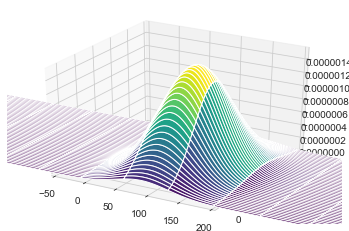

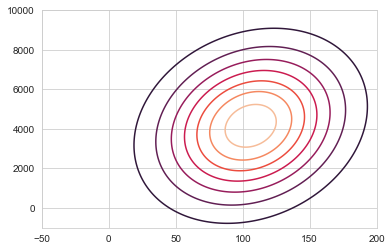

In [15]:
# 2. Math exp, Variance
sample = np.vstack((math_exp, var))
mean_vec_2 = np.mean(sample, axis=1)
cov_matrix_2 = np.cov(sample)
print('mean_vec: ', *mean_vec_2)
print('cov_matrix: \n', cov_matrix_2) 


x, y = np.mgrid[-500:3000, -1000:10000]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y
z = multivariate_normal(mean_vec_2, cov_matrix_2).pdf(position)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(-50, 200)
ax.set_ylim(-1000, 10000)
ax.plot_surface(x, y, z, cmap='viridis')
plt.show()

plt.xlim(-50, 200)
plt.ylim(-1000, 10000)
plt.contour(x, y, z)
plt.show()

In [16]:
# 3. Math exp, Variance, Skew
sample = np.vstack((math_exp, var, skew))
mean_vec_3 = np.mean(sample, axis=1)
cov_matrix_3 = np.cov(sample)
print('mean_vec: ', *mean_vec_3)
print('cov_matrix: \n', cov_matrix_3) 

mean_vec:  105.9661590844889 4160.092221752545 1.5763368919025729
cov_matrix: 
 [[   1857.94630719   21002.06131343      89.24294338]
 [  21002.06131343 5955650.51380816   -8044.58986736]
 [     89.24294338   -8044.58986736     151.29685831]]


In [17]:
# 4. Math exp, Variance, Skew, Kurtosis
sample = np.vstack((math_exp, var, skew, kurt))
mean_vec_4 = np.mean(sample, axis=1)
cov_matrix_4 = np.cov(sample)
print('mean_vec: ', *mean_vec_4)
print('cov_matrix: \n', cov_matrix_4)               

mean_vec:  105.9661590844889 4160.092221752545 1.5763368919025729 0.2871604457725356
cov_matrix: 
 [[   1857.94630719   21002.06131343      89.24294338     -46.93918196]
 [  21002.06131343 5955650.51380816   -8044.58986736    -137.13447242]
 [     89.24294338   -8044.58986736     151.29685831      -8.46525947]
 [    -46.93918196    -137.13447242      -8.46525947       1.89039792]]
